In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation

import numpy as np

import torch
import torch.nn

import torchsummary

from tqdm.notebook import tqdm

In [2]:
def get_dense_layers(num_features):

    acts = [torch.nn.Tanh() for _ in num_features[1:-1]]
    acts.append(torch.nn.Identity())
    layers = []
    for num_in, num_out, act in zip(num_features, num_features[1:], acts):
        layers.extend((torch.nn.Linear(num_in, num_out), act))
    return torch.nn.Sequential(*layers)


class OffenseModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = get_dense_layers([1, 100, 100, 1])

    def forward(self, X):
        X = X.view(-1, 1)
        X = self.main(X)
        X = X.view(-1, 1)
        X = torch.tanh(X)
        return X

model_o = OffenseModel()

In [3]:
def loss_function(x_all, mse=False, all_game_steps=False):
    if not all_game_steps:
        x_all = x_all[:, -1]
    x_dist = x_all - 0.9
    if mse:
        loss = (x_dist**2).mean()        
    else:
        loss = -torch.exp(-x_dist**2).mean()
    
    return loss

def simulation(model_o, x_init, tp=False):
    x_current = x_init
    x_all = [x_current]
    for i in range(100):
        x_current = x_current.clone()
        x_move = model_o(x_current)
        if tp:
            x_current = x_move
        else:
            x_current = (x_current + 0.02*x_move).clamp(-1, 1)
        x_all.append(x_current)
    return torch.cat(x_all, dim=-1)

In [4]:
tp = True
mse = True
all_game_steps = True
generate_func = torch.zeros

Loss:  0.3638995587825775


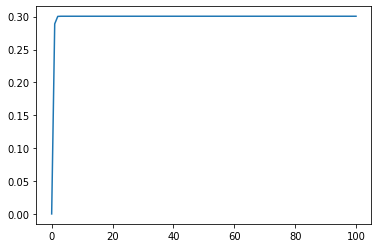

In [5]:
x_all = simulation(model_o, generate_func(1, 1), tp=tp)
print('Loss: ', loss_function(x_all, mse=mse, all_game_steps=all_game_steps).item())

plt.plot(np.arange(len(x_all[0])), x_all[0].detach().numpy())
plt.show()

In [6]:
opt = torch.optim.Adam(model_o.parameters())

pbar = tqdm(range(200))
for epoch in pbar:
    x_all = simulation(model_o, generate_func(19, 1), tp=tp)
    
    loss = loss_function(x_all, mse=mse, all_game_steps=all_game_steps)
    opt.zero_grad()
    loss.backward()
    grad_max = 0.0
    for params in model_o.parameters():
        grad = params.grad.abs().max() 
        if grad>grad_max:
            grad_max = grad
    opt.step()
    pbar.set_postfix({'Loss ': loss.item(), 'Grad Max': grad_max})

Loss:  0.008028368465602398


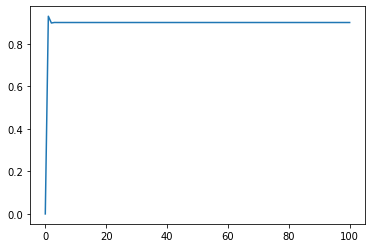

In [7]:
x_all = simulation(model_o, generate_func(1, 1), tp=tp)
print('Loss: ', loss_function(x_all, mse=mse, all_game_steps=all_game_steps).item())

plt.plot(np.arange(len(x_all[0])), x_all[0].detach().numpy())
plt.show()

things to mess around with:

- simulation by player steps vs player teleport
- loss function (guassian loss vs MSE loss)
- only last game_step vs all game_steps in loss function
- start from only zeros vs randn

---

- add timestamp to model input
- collision physics strict vs in loss function vs both
